**The spin systems (aka frames) in this experiment are defined by w1 and w2, which correspond to a covalently bonded C-H pair.**

---

> Remove any protons but the HN, HD, HE, HZ (all amide protons, bb and sc) from w3 before computing the per-frame intensity ranks and relative intensities and plot the distribution of 
* Intensity rank of CA(i)-HA(i)-HN(i) wrt any CA(i)-HA(i)-HN([0-9]+)
* Intensity rank of CA(i)-HA(i)-HN(i-1) wrt any CA(i)-HA(i)-HN([0-9]+)
* Intensity rank of CA(i)-HA(i)-HN(i+1) wrt any CA(i)-HA(i)-HN([0-9]+)
* Relative intensity of CA(i)-HA(i)-HN(i) wrt any CA(i)-HA(i)-HN([0-9]+)
* Relative intensity of CA(i)-HA(i)-HN(i-1) wrt any CA(i)-HA(i)-HN([0-9]+)
* Relative intensity of CA(i)-HA(i)-HN(i+1) wrt any CA(i)-HA(i)-HN([0-9]+)
* Do all the above but only for Gly, which has characteristic CA-HA shifts and not sidechain protons to diffuse the magentization.

 ---

> **For every amino acid type individually**, remove all HN, HD, HE (all amide protons, bb and sc), all HA and all aromatic protons from w3, and count how many times the most intense peak in the frame belongs to residue i and how many it doesn't.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.simplefilter('ignore')

from functions import *

pio.templates.default = "ggplot2"
px.defaults.width = 600
px.defaults.height = 400
pio.renderers.default = 'png'

In [2]:
pdb_ids = ['2K52', '2KD0', '2LTM', '2LF2', '2LTM', '2LX7']
heteronucleus = '13CALI'

In [3]:
df = concat_peak_lists(pdb_ids=pdb_ids, heteronucleus=heteronucleus)
print(f'Data aggregated from {df.pdb_id.unique().shape[0]} proteins.\n')
df

Data aggregated from 5 proteins.



,pdb_id,res,noe,X,Hn,H,height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos
0,2K52,M1CA,HA,55.325,4.091,4.091,120663,M1CA,False,1,1,0,HA,HA_i
1,2K52,M1CA,HB2,55.325,4.091,2.189,12652,M1CA,False,1,1,0,HB,HB_i
2,2K52,M1CA,HB3,55.325,4.091,2.076,10144,M1CA,False,1,1,0,HB,HB_i
3,2K52,M1CA,HE,55.325,4.091,2.041,11026,M1CA,False,1,1,0,HE,HE_i
4,2K52,M1CA,HG2,55.325,4.091,2.524,9269,M1CA,False,1,1,0,HG,HG_i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,2LX7,L60CG,HB2,27.900,1.510,1.560,57996,L60CG,False,60,60,0,HB,HB_i
3350,2LX7,L60CG,HB3,27.900,1.510,1.450,39606,L60CG,False,60,60,0,HB,HB_i
3351,2LX7,L60CG,HD1,27.900,1.510,0.760,2322,L60CG,False,60,60,0,HD,HD_i
3352,2LX7,L60CG,HD2,27.900,1.510,0.790,2330,L60CG,False,60,60,0,HD,HD_i


We are interested only $H^A$ - $C^A$ frames: remove the side-chain peaks

In [4]:
df = df[df['res'].str.endswith('CA')]
df.loc[:, 'res'] = df.res.str.removesuffix('CA')

In [5]:
df[df.pdb_id == np.random.choice(pdb_ids)].sample(5)

,pdb_id,res,noe,X,Hn,H,height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos
2490,2LX7,D46,L48H,53.5,4.51,7.90,110,L48,True,46,48,-2,H,H_i+2
1555,2LX7,L31,I29HG2,56.0,4.28,0.51,1086,I29,True,31,29,2,HG,HG_i-2
62,2LX7,G3,A4H,45.3,3.72,7.95,628,A4,True,3,4,-1,H,H_i+1
2625,2LX7,R49,G50HA3,54.3,5.77,4.39,-194,G50,True,49,50,-1,HA,HA_i+1
2324,2LX7,K44,E45HA,56.1,4.78,4.07,101,E45,True,44,45,-1,HA,HA_i+1


Simplifying the NOE contact categories: everything that's more than 1 residue away is now "far"

In [6]:
df.loc[df.res_diff.abs() > 1, "atom_type_pos"] = df.loc[df.res_diff.abs() > 1, "atom_type"] + "_far"

Removing the sign of the crosspeaks: here the phase does not matter.

In [7]:
df.loc[:, 'height'] = df.height.abs()

**Calculating the relative intensities for the frames**

Removing the non-amide protons

In [8]:
aa_sidechain_amide_protons = {
    'R': 'HH',
    'N': 'HD',
    'Q': 'HE',
    'H': 'HD',
    'K': 'HZ',
    'W': 'HE',
}

sc_amide_mask = df.apply(lambda row: is_sc_amide(row, aa_sidechain_amide_protons), axis=1)
df_hn = df[sc_amide_mask | (df.atom_type == 'H')]
df_hn.tail(7)

,pdb_id,res,noe,X,Hn,H,height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos
3132,2LX7,Q58,L59H,53.6,4.81,9.00,9,L59,True,58,59,-1,H,H_i+1
3193,2LX7,L59,R7H,56.7,4.30,8.79,382,R7,True,59,7,52,H,H_far
3195,2LX7,L59,Q58H,56.7,4.30,8.77,369,Q58,True,59,58,1,H,H_i-1
3198,2LX7,L59,H,56.7,4.30,9.00,698,L59CA,False,59,59,0,H,H_i
3205,2LX7,L59,L60H,56.7,4.30,8.00,5718,L60,True,59,60,-1,H,H_i+1
3272,2LX7,L60,L59H,56.7,4.21,9.00,461,L59,True,60,59,1,H,H_i-1
3276,2LX7,L60,H,56.7,4.21,8.00,978,L60CA,False,60,60,0,H,H_i


Calculating the relative intensities

In [9]:
df_hn.insert(7, 'rel_height', df_hn['height'].to_frame() / df_hn[['res', 'height']].groupby('res').transform('max'))

## Calculting atom ranks

In [10]:
df_hn = df_hn.drop_duplicates(['resnum', 'noe_resnum', 'atom_type_pos'])

In [11]:
df_hn['rank'] = df_hn[['pdb_id', 'res', 'rel_height']].groupby(['pdb_id', 'res'], as_index=False)["rel_height"]\
                        .rank(method='dense', ascending=False)\
                        .astype('category')

In [12]:
df_hn.tail(7)

,pdb_id,res,noe,X,Hn,H,height,rel_height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos,rank
2811,2LX7,P53,W40H,61.2,3.66,8.84,190,0.027681,W40,True,53,40,13,H,H_far,2.0
2907,2LX7,A54,W40HE3,54.8,2.87,7.38,684,0.377067,W40,True,54,40,14,HE,HE_far,1.0
3008,2LX7,V57,R7H,58.7,5.19,8.79,2738,0.699183,R7,True,57,7,50,H,H_far,1.0
3011,2LX7,V57,L9H,58.7,5.19,9.34,1715,0.437947,L9,True,57,9,48,H,H_far,2.0
3117,2LX7,Q58,R7H,53.6,4.81,8.79,3,0.068182,R7,True,58,7,51,H,H_far,2.0
3129,2LX7,Q58,HE21,53.6,4.81,7.64,30,0.681818,Q58CA,False,58,58,0,HE,HE_i,1.0
3193,2LX7,L59,R7H,56.7,4.30,8.79,382,0.066807,R7,True,59,7,52,H,H_far,1.0


### Leaving only Gly as residues $i$ (i.e. in w1 and w2 dimensions)

In [13]:
df_gly = df_hn[df_hn.res.str.match(r'^G')]
df_gly.duplicated().sum()

0

Duplicated data points occur when there is entry for both GlyHA2 and HA3 with the same chemical shift (which is the most comon sceario, because those protons are rarily distingushable physically)

In [14]:
df_gly.drop_duplicates(inplace=True)

In [15]:
print(f'We are dealing with the total of {(df_gly.pdb_id + df_gly.res).unique().shape[0]} frames')

We are dealing with the total of 28 frames


In [16]:
df_gly[df_gly.pdb_id == np.random.choice(pdb_ids)]

,pdb_id,res,noe,X,Hn,H,height,rel_height,noe_res,inter,resnum,noe_resnum,res_diff,atom_type,atom_type_pos,rank
1226,2LX7,G26,T8H,45.7,4.15,9.14,6,0.002171,T8,True,26,8,18,H,H_far,1.0
2213,2LX7,G42,L31H,45.6,4.99,8.96,1412,0.765312,L31,True,42,31,11,H,H_far,2.0
2215,2LX7,G42,L32H,45.6,4.99,9.19,1487,0.805962,L32,True,42,32,10,H,H_far,1.0
2230,2LX7,G42,G50H,45.6,4.99,8.71,158,0.085637,G50,True,42,50,-8,H,H_far,3.0
2234,2LX7,G42,T30H,45.6,3.73,8.81,87,0.047154,T30,True,42,30,12,H,H_far,4.0
2514,2LX7,G47,K44H,45.0,4.34,9.14,134,0.033694,K44,True,47,44,3,H,H_far,1.0
2692,2LX7,G50,G42H,46.1,4.51,9.13,2,0.001281,G42,True,50,42,8,H,H_far,3.0
2693,2LX7,G50,R49H,46.1,4.51,8.34,198,0.126842,R49,True,50,49,1,H,H_i-1,1.0
2705,2LX7,G50,L21H,46.1,4.39,9.28,88,0.056374,L21,True,50,21,29,H,H_far,2.0


$H^A_{Gly} -> C^A_{Gly} - > H^{amide}$

## Calculating the stats

In [17]:
query_atoms=["H_i", "H_i-1", "H_i+1"]

_ = df_gly.loc[df_gly.atom_type_pos.isin(query_atoms)]
rank_counts = _.groupby(['atom_type_pos', 'rank']).size().unstack(fill_value=0)
rank_counts.insert(3, "4+", rank_counts.iloc[:, 3:].sum(axis=1))
rank_counts = rank_counts.iloc[:, :4]
rank_counts.index.name = "Atom name"
rank_counts.columns = ["1st highest", "2nd highest", "3rd highest", "4th or lower"]

rank_counts.style.background_gradient(cmap='Greens')

,1st highest,2nd highest,3rd highest,4th or lower
Atom name,,,,
H_i,11,1,0,0
H_i+1,1,9,1,0
H_i-1,5,1,4,5


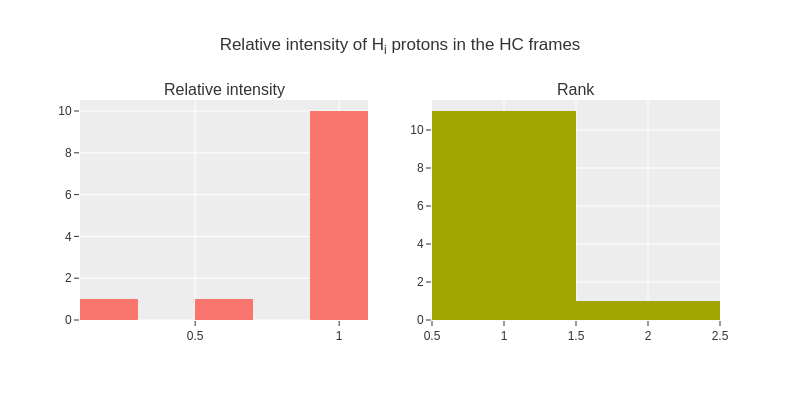

In [18]:
fig = make_subplots(rows=1, cols=2, 
                   subplot_titles=("Relative intensity","Rank"))

fig.add_trace(
    go.Histogram(x=df_gly.query('atom_type_pos == "H_i"')['rel_height']),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_gly.query('atom_type_pos == "H_i"')['rank']),
    row=1, col=2
)

fig.update_layout(height=400, width=800, showlegend=False, 
                  title_text="Relative intensity of H<sub>i</sub> protons in the HC frames")
fig.show()

In [23]:
df_gly.query('atom_type_pos == "H_i"')['rel_height']

316      1.000000
650      1.000000
1286     0.164219
2072     0.666126
3416     1.000000
6713     1.000000
7685     1.000000
5808     1.000000
8123     1.000000
9904     1.000000
10161    1.000000
11296    1.000000
Name: rel_height, dtype: float64

In [24]:
df_gly.query('atom_type_pos == "H_i"')['rank']

316      1.0
650      1.0
1286     1.0
2072     2.0
3416     1.0
6713     1.0
7685     1.0
5808     1.0
8123     1.0
9904     1.0
10161    1.0
11296    1.0
Name: rank, dtype: category
Categories (8, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

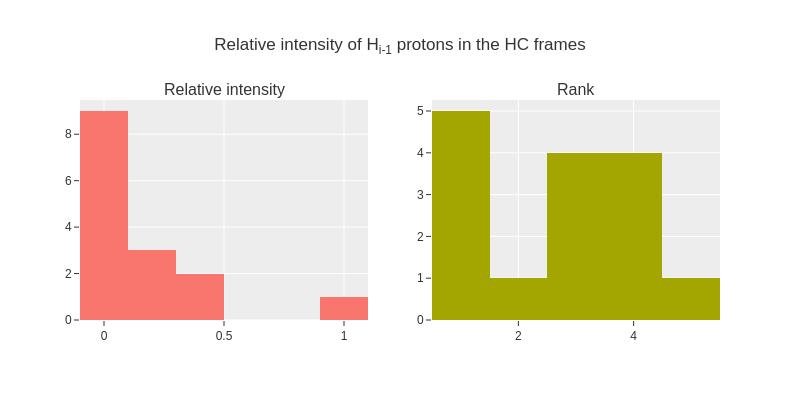

In [19]:
fig = make_subplots(rows=1, cols=2, 
                   subplot_titles=("Relative intensity","Rank"))

fig.add_trace(
    go.Histogram(x=df_gly.query('atom_type_pos == "H_i-1"')['rel_height']),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_gly.query('atom_type_pos == "H_i-1"')['rank']),
    row=1, col=2
)

fig.update_layout(height=400, width=800, showlegend=False, 
                  title_text="Relative intensity of H<sub>i-1</sub> protons in the HC frames")
fig.show()

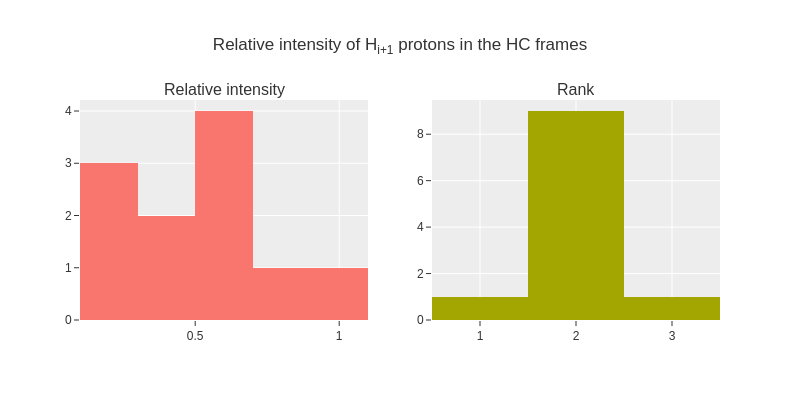

In [20]:
fig = make_subplots(rows=1, cols=2, 
                   subplot_titles=("Relative intensity","Rank"))

fig.add_trace(
    go.Histogram(x=df_gly.query('atom_type_pos == "H_i+1"')['rel_height']),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_gly.query('atom_type_pos == "H_i+1"')['rank']),
    row=1, col=2
)

fig.update_layout(height=400, width=800, showlegend=False, 
                  title_text="Relative intensity of H<sub>i+1</sub> protons in the HC frames")
fig.show()